# Автокодировщики и автокодирование

In [156]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные в loader'ы

In [157]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(
    root=r"C:\Users\mikhail.klyazhev\Desktop\study\git\otus_ds\DL\hw-3\dataset",
    train=True,
    download=False,
    transform=data_transforms
)

test_dataset = datasets.MNIST(
    root=r"C:\Users\mikhail.klyazhev\Desktop\study\git\otus_ds\DL\hw-3\dataset",
    train=False,
    download=True,
    transform=data_transforms
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True
)

## Multilayer Autoencoder

Определим классы автокодировщика

In [158]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.sequential(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.sequential(x)
        return x

In [159]:
class MultilayerAutoencoder(nn.Module):
    def __init__(self, loss_fn=F.mse_loss, lr=1e-3, l2=1e-5):
        super(MultilayerAutoencoder, self).__init__()
        self.E = Encoder()
        self.D = Decoder()
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.E(x)
        decoded = self.D(encoded)
        return decoded
    
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
    
    def decode(self, x):
        with torch.no_grad():
            return self.D(x)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [160]:
def add_noise(x, mode='crop', elementwise=False):
    if np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                if np.random.randint(2):
                    x[i] = np.flip(x[i], axis=2)
                    x[i] = np.flip(x[i], axis=3)
        elif mode == 'gaussian':
            for i in range(x.shape[0]):
                std_dev = np.random.uniform(0.01, 0.1)
                noise = np.random.normal(0, std_dev, x[i].shape)
                x[i] += noise
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            if np.random.randint(2):
                x = np.flip(x, axis=2)
                x = np.flip(x, axis=3)
        elif mode == 'gaussian':
            std_dev = np.random.uniform(0.01, 0.1)
            noise = np.random.normal(0, std_dev, x.shape)
            x += noise
    return x

In [161]:
def train(epoch, model, loader, noise=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(loader):
        target = data.detach().clone()
        if noise:
            data = add_noise(data)
        output = model(data)
        loss = model.loss(output, target)
        
        model.optim.zero_grad()
        loss.backward()
        model.optim.step()

        if batch_idx % 150 == 0:
            line = "Train Epoch: {} [{:05d}/{}] ".format(
                epoch, batch_idx * len(data), train_size
            )
            loss = "Loss: {:.6f}".format(loss.item())
            print(line + loss)

In [162]:
def test(model, loader, noise=False):
    test_size = len(loader.sampler)
    test_loss = 0.
    
    with torch.no_grad():
        for data, _ in loader:
            target = data.detach().clone()
            if noise:
                data = add_noise(data)
            output = model(data)
            test_loss += model.loss(output, target, reduction='sum').item()
    
    test_loss /= (test_size * 784)
    
    loss = "Test loss: {:.6f}".format(test_loss)  
    print(loss)

Обучим автокодировщик

In [163]:
model = MultilayerAutoencoder()

for epoch in range(1, 21):
    model.train()
    train(epoch, model, train_loader)
    
    model.eval()
    test(model, test_loader)

Train Epoch: 1 [00000/60000] Loss: 0.941226
Train Epoch: 1 [09600/60000] Loss: 0.236938
Train Epoch: 1 [19200/60000] Loss: 0.166189
Train Epoch: 1 [28800/60000] Loss: 0.148532
Train Epoch: 1 [38400/60000] Loss: 0.122215
Train Epoch: 1 [48000/60000] Loss: 0.116788
Train Epoch: 1 [57600/60000] Loss: 0.115301
Test loss: 0.105185
Train Epoch: 2 [00000/60000] Loss: 0.105448
Train Epoch: 2 [09600/60000] Loss: 0.096786
Train Epoch: 2 [19200/60000] Loss: 0.096688
Train Epoch: 2 [28800/60000] Loss: 0.093090
Train Epoch: 2 [38400/60000] Loss: 0.089960
Train Epoch: 2 [48000/60000] Loss: 0.081484
Train Epoch: 2 [57600/60000] Loss: 0.092238
Test loss: 0.082440
Train Epoch: 3 [00000/60000] Loss: 0.076365
Train Epoch: 3 [09600/60000] Loss: 0.080438
Train Epoch: 3 [19200/60000] Loss: 0.079861
Train Epoch: 3 [28800/60000] Loss: 0.067488
Train Epoch: 3 [38400/60000] Loss: 0.074908
Train Epoch: 3 [48000/60000] Loss: 0.074989
Train Epoch: 3 [57600/60000] Loss: 0.078916
Test loss: 0.071141
Train Epoch: 4 [

Отрисуем классы после прогона изображения через модель

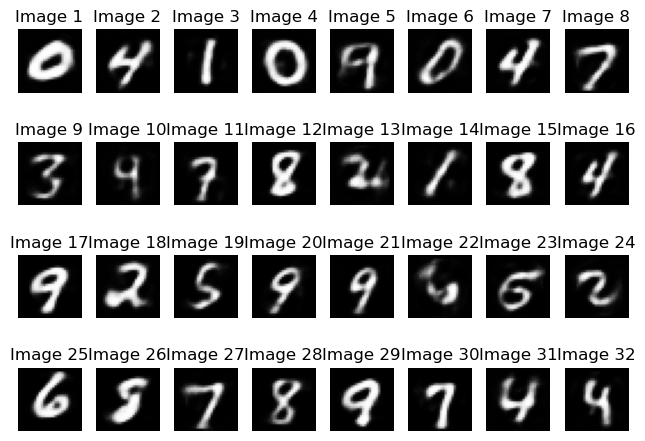

In [164]:
for sample, _ in train_loader:
    with torch.no_grad():
        output = model(sample)
    output = e.view(-1, 1, 28, 28).reshape(-1, 28, 28)
    
    fig, axes = plt.subplots(4, 8)
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(output.detach().numpy()[i], cmap='gray')
        ax.set_title(f'Image {i + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    break

Отрисуем t-SNE представление данных после прохода через модель-кодировщик

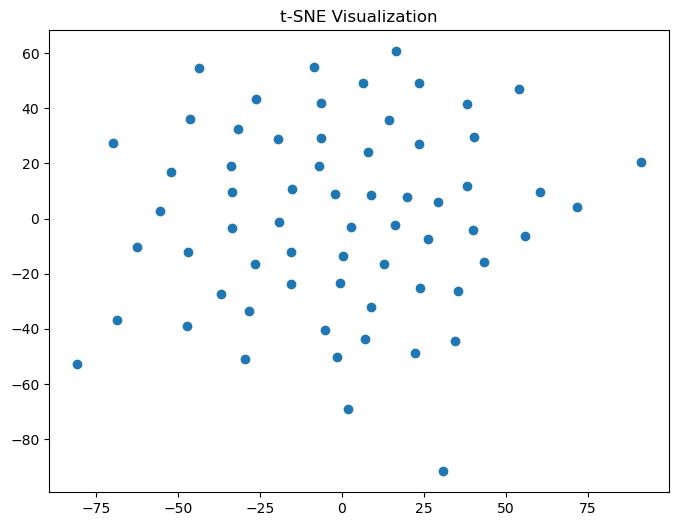

In [165]:
sample = next(iter(train_loader))[0]
sample = sample.view(-1, 28*28)

with torch.no_grad():
    output = model.encode(sample)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedded_sample = tsne.fit_transform(output)

plt.figure(figsize=(8, 6))
plt.scatter(embedded_sample[:, 0], embedded_sample[:, 1])
plt.title("t-SNE Visualization")
plt.show()

# Noised Autoencoder

Обучим автокодировщик на данных с шумом

In [166]:
noised_model = MultilayerAutoencoder()

for epoch in range(1, 21):
    noised_model.train()
    train(epoch, noised_model, train_loader, noise=True)
    
    noised_model.eval()
    test(noised_model, test_loader, noise=True)

Train Epoch: 1 [00000/60000] Loss: 0.043772
Train Epoch: 1 [09600/60000] Loss: 0.229374
Train Epoch: 1 [19200/60000] Loss: 0.055611
Train Epoch: 1 [28800/60000] Loss: 0.118766
Train Epoch: 1 [38400/60000] Loss: 0.097675
Train Epoch: 1 [48000/60000] Loss: 0.074269
Train Epoch: 1 [57600/60000] Loss: 0.057546
Test loss: 0.086400
Train Epoch: 2 [00000/60000] Loss: 0.213875
Train Epoch: 2 [09600/60000] Loss: 0.190058
Train Epoch: 2 [19200/60000] Loss: 0.161989
Train Epoch: 2 [28800/60000] Loss: 0.114753
Train Epoch: 2 [38400/60000] Loss: 0.101646
Train Epoch: 2 [48000/60000] Loss: 0.098882
Train Epoch: 2 [57600/60000] Loss: 0.094312
Test loss: 0.082857
Train Epoch: 3 [00000/60000] Loss: 0.051750
Train Epoch: 3 [09600/60000] Loss: 0.090533
Train Epoch: 3 [19200/60000] Loss: 0.062344
Train Epoch: 3 [28800/60000] Loss: 0.096635
Train Epoch: 3 [38400/60000] Loss: 0.159885
Train Epoch: 3 [48000/60000] Loss: 0.062264
Train Epoch: 3 [57600/60000] Loss: 0.057750
Test loss: 0.089287
Train Epoch: 4 [

Отрисуем матрицу весов 1-го слоя

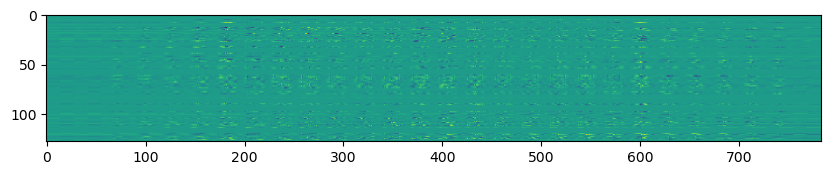

In [167]:
plt.figure(figsize=(10, 6))
plt.imshow(model.E.sequential[0].weight.detach().numpy())

Посмотрим, как выглядят данные после прохода через первый слой (получается вектор, поэтому отобразим в виде гистограммы)

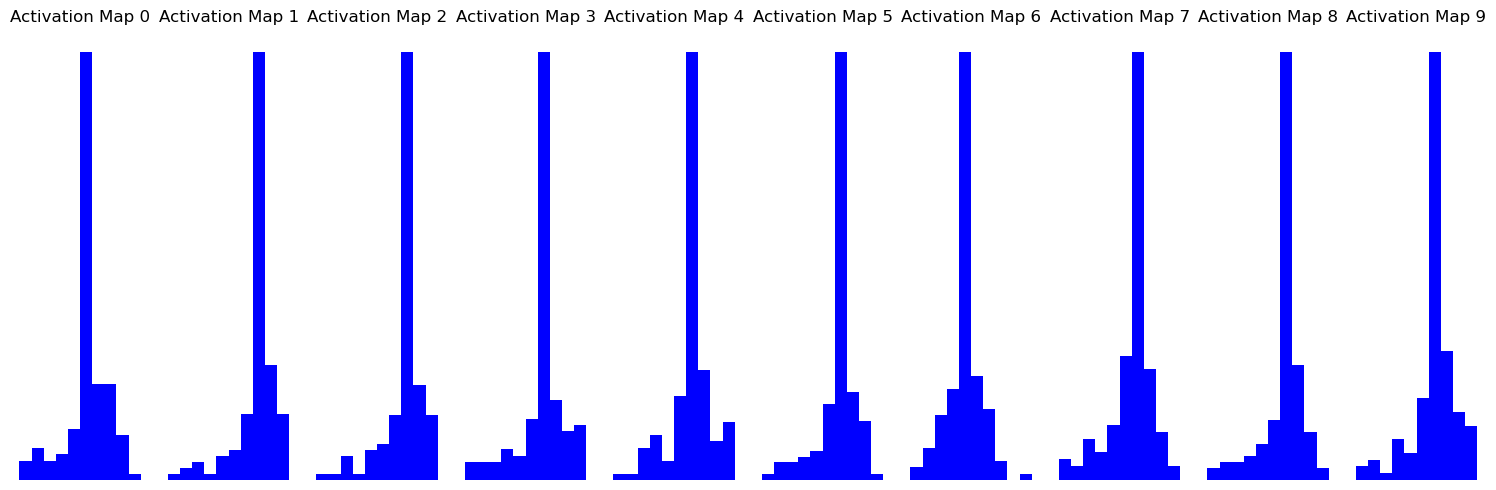

In [185]:
noised_model.eval()

with torch.no_grad():
    activations = noised_model.E.sequential[0](sample)
    
num_activations = 10  # выведем только 10 первых примеров

fig, axes = plt.subplots(1, num_activations, figsize=(15, 5))

for i in range(num_activations):
    activation_map = activations[i].cpu().numpy()
    axes[i].hist(activation_map, color='blue')
    axes[i].set_title(f'Activation Map {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()